In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
# from deepproblog.dataset import Dataset, DataLoader, QueryDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
from deepproblog.dataset import Dataset as DPLDataset
from problog.logic import Term, Constant, Var, list2term
from deepproblog.dataset import ImageDataset
from deepproblog.evaluate import get_confusion_matrix
from torch.amp.autocast_mode import autocast
from torchvision import models, transforms, datasets
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from deepproblog.dataset import DataLoader as DPLDataLoader

import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from deepproblog.utils.stop_condition import EpochStop
from deepproblog.optimizer import SGD

from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.engines import ExactEngine
from deepproblog.query import Query
from deepproblog.train import train_model
import torch.nn as nn
import torch.nn.functional as F

from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import glob
from retinaface import RetinaFace
import csv

c:\Users\jarne\miniconda3\envs\dpl_base\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# GLOBAL VARS
dataset_size = None
batch_size = 32
log_iter = 2
global_emotion_label = 'emo8'

In [3]:
# Directories
script_dir = os.getcwd()
print("script_dir:", script_dir)
base_dir = os.path.dirname(os.path.dirname(script_dir))
print("base_dir:", base_dir)
prolog_dir = os.path.join(base_dir, "prolog")
data_dir = os.path.join(base_dir, "data")
print("data_dir:", data_dir)
findingemo_dir = os.path.join(data_dir, "FindingEmo_Images")
print("findingemo_dir:", findingemo_dir)
prolog_dir = os.path.join(base_dir, "code", "prolog")
print("prolog_dir:", prolog_dir)
model_dir = os.path.join(base_dir, "code", "models")
print("model_dir:", model_dir)
cropped_faces_dir = os.path.join(findingemo_dir, "faces")
print("cropped_faces_dir:", cropped_faces_dir)

script_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\notebooks
base_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition
data_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data
findingemo_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images
prolog_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog
model_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\models
cropped_faces_dir: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\data\FindingEmo_Images\faces


In [4]:
df = pd.read_pickle(os.path.join(script_dir, "clean_findingemo.pkl"))
print("Dataframe loaded. Number of entries:", len(df))

Dataframe loaded. Number of entries: 25867


In [5]:
EMOTION_SETS = [["Serenity", "Joy", "Ecstasy"],
                    ["Acceptance", "Trust", "Admiration"],
                    ["Apprehension", "Fear", "Terror"],
                    ["Distraction", "Surprise", "Amazement"],
                    ["Pensiveness", "Sadness", "Grief"],
                    ["Boredom", "Disgust", "Loathing"],
                    ["Annoyance", "Anger", "Rage"],
                    ["Interest", "Anticipation", "Vigilance"]]
                
def emo_8_mapping(e):
    for leaf in EMOTION_SETS:
        if e in leaf:
            return leaf[1]
        
def emo_3_mapping(v):
    if v < -1:
        return "sad"
    if v > 1:
        return "happy"
    else:
        return "neutral"

In [6]:
if global_emotion_label == 'emo8':
    df['emotion'] = df['emotion'].apply(emo_8_mapping).str.lower()
if global_emotion_label == 'emotion':
    df['emotion'] = df['emotion'].str.lower()
if global_emotion_label == 'emo3':
    df['emotion'] = df['valence'].apply(emo_3_mapping).str.lower()

In [7]:
df.head()

,image_path,tags,age,valence,arousal,emotion,dec_factors,ambiguity
0,Run_2/Loving toddlers sports/haiti-kids.jpg,Undefined,Children,0,2,trust,"BodyLanguage,FacialExpression",0
1,Run_2/Frustrated forty-something office/team-w...,Undefined,Young Adults,0,2,anticipation,FacialExpression,0
2,Run_1/Violent youth festival/1042373588.jpg,Undefined,Young Adults,2,2,anticipation,BodyLanguage,3
3,Run_2/Remorseful toddlers court of law/dcfs-co...,Undefined,Adults,1,2,anticipation,"BodyLanguage,FacialExpression",4
4,Run_2/Shame elderly sports/3364887-46.jpg,Undefined,Adults,0,3,fear,ConflictCtxtPerson,0


In [8]:
len(df)

25867

In [9]:
if dataset_size is not None:
    df = df.iloc[:dataset_size]

In [10]:
fe_labels = df['emotion'].unique().tolist()
fe_labels.sort()
print("Emotion labels:", fe_labels)

Emotion labels: ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']


In [11]:
fer_classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [12]:
# Load category names
scene_categories_path = os.path.join(data_dir, "places365/categories_places365.txt")
with open(scene_categories_path) as f:
    scene_categories = [line.strip().split(' ')[0][3:] for line in f]
    # If there is a / in the category name, replace it with _
    scene_categories = [cat.replace('/', '_') for cat in scene_categories]
print("Length of scene categories:", len(scene_categories))  # Should be 365

Length of scene categories: 365


In [13]:
# get the counts of the labels of emotion
df['emotion'].value_counts()

emotion
joy             7024
anticipation    5901
trust           3549
sadness         2665
anger           2439
fear            2401
disgust         1000
surprise         888
Name: count, dtype: int64

In [14]:
if dataset_size is not None:
    N = dataset_size
else:
    N = len(df)
    
indices = list(range(N))

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
print("Train indices length:", len(train_indices))
print("Test indices length:", len(test_indices))

Train indices length: 20693
Test indices length: 5174


In [15]:
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# let cuDNN pick the fastest kernels for this image size
torch.backends.cudnn.benchmark = True

True


In [16]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, AutoConfig

emotion_transform = AutoImageProcessor.from_pretrained("trpakov/vit-face-expression", use_fast=True)
face_model_base = AutoModelForImageClassification.from_pretrained("trpakov/vit-face-expression")
face_model_base.to(DEVICE)
config = AutoConfig.from_pretrained("trpakov/vit-face-expression")
print(config.id2label)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [17]:
scene_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained Places365 ResNet18
scene_model_base = models.resnet18(num_classes=365)
weights_url = "http://places2.csail.mit.edu/models_places365/resnet18_places365.pth.tar"
checkpoint = torch.hub.load_state_dict_from_url(weights_url, map_location="cpu")
state_dict = {k.replace("module.", ""): v for k, v in checkpoint["state_dict"].items()}
scene_model_base.load_state_dict(state_dict)
scene_model_base.to(DEVICE)
print("Loaded pretrained models")

Loaded pretrained models


In [18]:
df_boxes = pd.read_csv(os.path.join(findingemo_dir, "face_boxes_5.csv"))
# Based on boxes_df we can add the column nr_faces for each original image in df
df['nr_faces'] = df.index.map(df_boxes['index'].value_counts()).fillna(0).astype(int)

In [19]:
get_category_name = lambda idx: scene_categories[idx]

In [20]:
scene_priors_path = os.path.join(data_dir, "scene_priors.xlsx")
scene_priors = pd.read_excel(scene_priors_path, index_col=0)
scene_priors.head()

,valence,arousal,nr_samples
scene_category,,,
airfield,4.000000,3.000000,2
airplane_cabin,3.059829,3.025641,117
airport_terminal,2.952381,2.190476,42
alcove,4.000000,1.000000,1
alley,3.130435,2.608696,23


In [21]:
def remove_brackets(lst):  
    return ', '.join(lst)

In [22]:
# Create the prolog file
prolog_file_name = "model7.pl"
prolog_file_path = os.path.join(prolog_dir, prolog_file_name)
with open(prolog_file_path, "w") as f:

    f.write("nn(face_model, [Face], Emotion,\n")
    f.write("   [angry, disgust, fear, happy, neutral, sad, surprise]) ::\n")
    f.write("   face_emotion(Face, Emotion).\n\n")

    f.write(f"nn(scene_model, [ScenePredictions], Scene, [{remove_brackets(list(scene_priors.index))}]) ::\n")
    f.write("   scene(ScenePredictions, Scene).\n\n")

    f.write(f"nn(va_to_emotion_model, [CombinedValence, CombinedArousal], Emotion,\n")
    f.write(f"   [{remove_brackets(list(fe_labels))}]) ::\n")
    f.write("   va_to_emotion(CombinedValence, CombinedArousal, Emotion).\n\n")

    for scene, row, in scene_priors.iterrows():
        if not (np.isnan(row['valence']) or np.isnan(row['arousal'])):
            f.write(f"scene_prior({scene}, {round(row['valence'], 2)}, {round(row['arousal'], 2)}).\n")
        else:
            # allocate random values for valence and arousal between 0 and 6
            valence = round(random.uniform(0, 6), 2)
            arousal = round(random.uniform(0, 6), 2)
            f.write(f"scene_prior({scene}, {valence}, {arousal}).\n")

    # Next step model these with gaussian distribution so we don't always have fixed values, maybe also for the scene priors
    f.write("\n")
    f.write("face_prior(angry, 1.2, 5.1).\n")
    f.write("face_prior(disgust, 0.9, 3.1).\n")
    f.write("face_prior(fear, 0.6, 5.4).\n")
    f.write("face_prior(happy, 5.4, 4.8).\n")
    f.write("face_prior(neutral, 3.0, 2.4).\n")
    f.write("face_prior(sad, 0.9, 1.5).\n")
    f.write("face_prior(surprise, 3.3, 5.4).\n")
    f.write("\n")

    f.write("small_diff(F, S)  :- abs(F - S) =< 1.\n")
    f.write("medium_diff(F, S) :- D is abs(F - S), D > 1, D =< 3.\n")
    f.write("large_diff(F, S)  :- abs(F - S) > 3.\n")

    f.write("\n")
    f.write(f"t(_) :: use_face_small_val(F,S) ; t(_) :: use_scene_small_val(F,S).\n")
    f.write(f"t(_) :: use_face_small_aro(F,S) ; t(_) :: use_scene_small_aro(F,S).\n")
    f.write(f"t(_) :: use_face_big_val(F,S) ; t(_) :: use_scene_big_val(F,S).\n")
    f.write(f"t(_) :: use_face_big_aro(F,S) ; t(_) :: use_scene_big_aro(F,S).\n")
    f.write("\n")

    f.write("combine_val(FV, SV, FV) :-\n")
    f.write("    small_diff(FV, SV), \n")
    f.write("    use_face_small_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(FV, SV, SV) :-\n")
    f.write("    small_diff(FV, SV), \n")
    f.write("    use_scene_small_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(F, S, M) :-\n")
    f.write("    medium_diff(F, S), \n")
    f.write("    M is (2*F + S) / 3. \n")
    f.write("\n")
    f.write("combine_val(FV, SV, FV) :-\n")
    f.write("    large_diff(FV, SV), \n")
    f.write("    use_face_big_val(FV, SV). \n")
    f.write("\n")
    f.write("combine_val(FV, SV, SV) :-\n")
    f.write("    large_diff(FV, SV), \n")
    f.write("    use_scene_big_val(FV, SV). \n")
    f.write("\n")

    f.write("combine_aro(FA, SA, FA) :-\n")
    f.write("    small_diff(FA, SA), \n")
    f.write("    use_face_small_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, SA) :-\n")
    f.write("    small_diff(FA, SA), \n")
    f.write("    use_scene_small_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(F, S, M) :-\n")
    f.write("    medium_diff(F, S), \n")
    f.write("    M is (2*F + S) / 3. \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, FA) :-\n")
    f.write("    large_diff(FA, SA), \n")
    f.write("    use_face_big_aro(FA, SA). \n")
    f.write("\n")
    f.write("combine_aro(FA, SA, SA) :-\n")
    f.write("    large_diff(FA, SA), \n")
    f.write("    use_scene_big_aro(FA, SA). \n")
    f.write("\n")
    
    f.write("final_emotion(FacePredictions, ScenePredictions, Emotion) :-\n")
    f.write("    face_emotion(FacePredictions, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(ScenePredictions, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA),\n")
    f.write("    combine_val(FV, SV, CV),\n")
    f.write("    combine_aro(FA, SA, CA),\n")
    f.write("    va_to_emotion(CV, CA, Emotion). \n")
    f.write("\n")

    f.write("test_va(FacePredictions, ScenePredictions, FV, FA, SV, SA) :-\n")
    f.write("    face_emotion(FacePredictions, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(ScenePredictions, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA).\n")
    f.write("\n")
    
    f.write("test_combo(FacePredictions, ScenePredictions, CV, CA) :-\n")
    f.write("    face_emotion(FacePredictions, FaceEmotion),\n")
    f.write("    face_prior(FaceEmotion, FV, FA),\n")
    f.write("    scene(ScenePredictions, Scene),\n")
    f.write("    scene_prior(Scene, SV, SA),\n")
    f.write("    combine_val(FV, SV, CV),\n")
    f.write("    combine_aro(FA, SA, CA).\n")
    f.write("\n")

print("Prolog file written to:", prolog_file_path)

Prolog file written to: c:\Users\jarne\Documents\Code Masterthesis\nsai_social_cognition\code\prolog\model7.pl


In [23]:
class FacePredictionsDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        face_rows = df_boxes[df_boxes['index'] == idx].sort_values('face_rank')
        face_features_list = []
        for _, box_row in face_rows.iterrows():
            face_rank = int(box_row['face_rank'])
            face_prediction_file = os.path.join(self.feature_dir, "faces", f"face_{idx}_{face_rank}.pt")
            face_features = torch.load(face_prediction_file, map_location="cpu")  # 
            face_features_list.append(face_features)

        if len(face_features_list) == 0:
            face_avg = torch.zeros(7, dtype=torch.float32)
        else:
            face_avg = torch.stack(face_features_list).mean(dim=0)

        return face_avg
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

face_predictions = FacePredictionsDataset(indices, os.path.join(data_dir, "pretrained_logits"))

In [24]:
# Maybe precalculate these again with blurred faces in scenes folder of pretrained_logits
class ScenePredictionsDataset(DPLDataset):
    def __init__(self, indices, feature_dir):
        self.indices = indices
        self.feature_dir = feature_dir

    def __getitem__(self, idx):
        if isinstance(idx, (tuple, list)):
            idx = idx[0]
        if isinstance(idx, Constant):
            idx = int(idx.value)

        scene_prediction_file = os.path.join(self.feature_dir, "scenes", f"scene_{idx}.pt")
        scene_features = torch.load(scene_prediction_file, map_location="cpu") 

        return scene_features
    
    def __len__(self):
        return len(self.indices)
    
    def to_query(self, i):
        pass

scene_predictions = ScenePredictionsDataset(indices, os.path.join(data_dir, "pretrained_logits"))

In [25]:
class FaceNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable temperature so outputs require grad
        self.temp = nn.Parameter(torch.tensor(1.0))

    def forward(self, tensor):
        """
        Load all face logits for an image, average logits across faces, then softmax once.
        """
        probs = torch.softmax(tensor * self.temp, dim=-1)           # (num_classes,)
        return probs

In [26]:
face_model_torch = FaceNet()
face_network = Network(face_model_torch, "face_model", batching=True)
face_network.optimizer = optim.Adam(face_model_torch.parameters(), lr=0.001)

In [27]:
class SceneNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Learnable temperature so outputs require grad
        self.temp = nn.Parameter(torch.tensor(1.0))
    def forward(self, tensor):
        """
        Load all face logits for an image, average logits across faces, then softmax once.
        """
        probs = torch.softmax(tensor * self.temp, dim=-1)           # (num_classes,)
        return probs

In [28]:
scene_model_torch = SceneNet()
scene_network = Network(scene_model_torch, "scene_model", batching=True)
scene_network.optimizer = optim.Adam(scene_model_torch.parameters(), lr=0.001)

In [29]:
combined_va_centroids = {'anger': (2.4171032456116555, 3.019359600458155),
                        'anticipation': (2.8101052960354296, 2.90118067312196),
                        'disgust': (2.561769099363139, 2.781531264549843),
                        'fear': (2.4226634795792754, 2.7616159987215667),
                        'joy': (3.8179193984605413, 3.4802071510276194),
                        'sadness': (2.305686367051083, 2.63678745898695),
                        'surprise': (2.9985175076110635, 3.067898037308043),
                        'trust': (3.2087952323808873, 3.0928009251717663)}

In [30]:
# Convert to tensor in correct label order
centroid_tensor = torch.tensor(
    [combined_va_centroids[l] for l in fe_labels],
    dtype=torch.float32
)   # shape (8, 2)

In [31]:
class VAtoEmotionNet(nn.Module):
    def __init__(self, base_centroids, init_tau=0.3):
        super().__init__()

        # Store base centroids (not trainable)
        self.register_buffer("base_centroids", base_centroids)  # (8,2)

        # Learnable centroid offsets Δμ
        self.centroid_offsets = nn.Parameter(torch.zeros_like(base_centroids))

        # Learnable inverse temperature
        self.log_inv_tau = nn.Parameter(torch.log(torch.tensor(1.0 / init_tau)))

    def forward(self, *inputs):
        """
        Supports forward(valence, arousal) or forward([[v,a], ...]).
        """

        # -----------------------------
        # CASE 1: single tensor (B, 2)
        # -----------------------------
        if len(inputs) == 1:
            x = inputs[0]

            if x.dim() == 1:
                x = x.unsqueeze(0)

        # -----------------------------
        # CASE 2: two separate tensors (B,) and (B,)
        # -----------------------------
        elif len(inputs) == 2:
            val, aro = inputs

            val = val.squeeze(-1) if val.dim() > 1 else val
            aro = aro.squeeze(-1) if aro.dim() > 1 else aro

            x = torch.stack([val, aro], dim=1)

        else:
            raise RuntimeError("VAtoEmotionNet: unexpected number of inputs")

        # -----------------------------
        # Compute adjusted centroids
        # -----------------------------
        centroids = self.base_centroids + self.centroid_offsets  # (8,2)

        # -----------------------------
        # Compute squared distances
        # -----------------------------
        diff = x.unsqueeze(1) - centroids.unsqueeze(0)  # (B,8,2)
        d2 = (diff * diff).sum(dim=-1)                  # (B,8)

        # Temperature
        inv_tau = torch.exp(self.log_inv_tau)
        logits = -inv_tau * d2

        return torch.softmax(logits, dim=1)


va_to_emotion_model = VAtoEmotionNet(centroid_tensor, init_tau=0.3)

va_to_emotion_network = Network(
    va_to_emotion_model,
    "va_to_emotion_model",
    batching=True
)

va_to_emotion_network.optimizer = optim.Adam(
    va_to_emotion_model.parameters(),
    lr=0.001
)

In [32]:
def show_pretrained_model_predictions_on_sample(sample_idx):
    row = df.iloc[sample_idx]
    img_path = os.path.join(findingemo_dir, row['image_path'])
    img = Image.open(img_path).convert("RGB")
    
    # Convert to numpy array for drawing
    img_array = np.array(img)
    
    # Get all face boxes for this image
    face_boxes = df_boxes[df_boxes['index'] == sample_idx].sort_values('face_rank')
    
    # Draw bounding boxes and predictions on the image
    for _, box_row in face_boxes.iterrows():
        x1, y1, x2, y2 = int(box_row['x1']), int(box_row['y1']), int(box_row['x2']), int(box_row['y2'])
        face_rank = int(box_row['face_rank'])
        
        model_output = torch.load(os.path.join(data_dir, "pretrained_logits", "faces", f"face_{sample_idx}_{face_rank}.pt")).to(DEVICE).unsqueeze(0)
        probs_output = torch.softmax(model_output, dim=1)
        probs = probs_output[0].cpu().detach().numpy()
        
        # Get top prediction
        top_idx = np.argmax(probs)
        top_label = f"{fer_classes[top_idx]}: {probs[top_idx]:.2f}"
        
        # Draw rectangle
        cv2.rectangle(img_array, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        # Calculate text size for better positioning
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        thickness = 2
        (text_width, text_height), baseline = cv2.getTextSize(top_label, font, font_scale, thickness)
        
        # Position text above the box if there's space, otherwise below
        if y1 - text_height - 10 > 0:
            text_y = y1 - 10
        else:
            text_y = y2 + text_height + 10
        
        # Draw text with background for better visibility
        cv2.rectangle(img_array, (x1, text_y - text_height - 5), 
                    (x1 + text_width + 5, text_y + 5), (0, 255, 0), -1)
        cv2.putText(img_array, top_label, (x1, text_y), 
                    font, font_scale, (0, 0, 0), thickness)
        
    # Display image with bounding boxes and predictions
    plt.figure(figsize=(15, 10))
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(f"Image Index: {sample_idx}, Valence: {row['valence']}, Arousal: {row['arousal']}, Emotion: {row['emotion']}", fontsize=16)
    plt.show()

    scene_logits = torch.load(os.path.join(data_dir, "pretrained_logits", "scenes", f"scene_{sample_idx}.pt")).to(DEVICE)
    scene_probs = torch.softmax(scene_logits, dim=0)
   

    # Show top 3 from base model (365 categories)
    top3_base = torch.topk(scene_probs, 3)
    print("Base model (365 categories):")
    for prob, idx in zip(top3_base.values.cpu(), top3_base.indices.cpu()):
        print(f"  {get_category_name(idx)}: {prob:.4f}")
    print("")


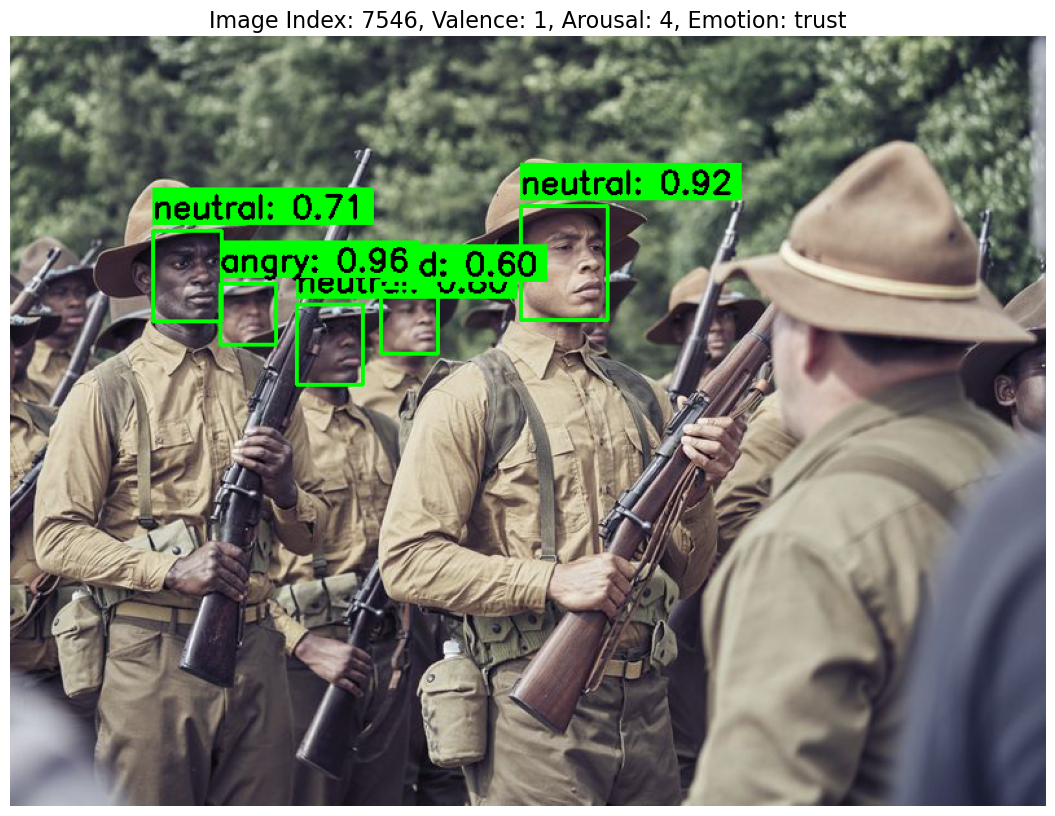

Base model (365 categories):
  army_base: 0.9927
  slum: 0.0017
  landfill: 0.0015



In [33]:
random_sample_idx = random.randint(0, len(df) - 1)
show_pretrained_model_predictions_on_sample(random_sample_idx)

In [34]:
from deepproblog.utils.confusion_matrix import ConfusionMatrix

from sklearn.metrics import confusion_matrix as sklearn_cm, precision_recall_fscore_support

def evaluate_dpl_with_metrics(model, dataset):
    """Enhanced DPL evaluate function that returns detailed metrics"""
    from deepproblog.utils.confusion_matrix import ConfusionMatrix
    
    confusion_matrix = ConfusionMatrix()
    model.eval()
    
    all_labels = []
    all_preds = []
    
    for i, gt_query in enumerate(tqdm(dataset.to_queries(), desc="Evaluating DPL", leave=False)):
        test_query = gt_query.variable_output()
        answer = model.solve([test_query])[0]
        actual = str(gt_query.output_values()[0])
        
        if len(answer.result) == 0:
            predicted = "no_answer"
        else:
            max_ans = max(answer.result, key=lambda x: answer.result[x])
            p = answer.result[max_ans]
            predicted = str(max_ans.args[gt_query.output_ind[0]])
        
        confusion_matrix.add_item(predicted, actual)
        all_labels.append(actual)
        all_preds.append(predicted)
    
    # Convert emotion labels to indices
    label_to_idx = {emo: i for i, emo in enumerate(fe_labels)}
    y_true = np.array([label_to_idx.get(label, -1) for label in all_labels])
    y_pred = np.array([label_to_idx.get(pred, -1) for pred in all_preds])
    
    # Remove any "no_answer" predictions (-1)
    valid_mask = (y_true >= 0) & (y_pred >= 0)
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    
    # Calculate sklearn confusion matrix
    cm = sklearn_cm(y_true, y_pred, labels=range(len(fe_labels)))
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, labels=range(len(fe_labels)), zero_division=0
    )
    
    # Overall accuracy
    accuracy = confusion_matrix.accuracy()
    result =  {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'dpl_confusion_matrix': confusion_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'support': support
    }
    print_dpl_detailed_metrics(result, fe_labels)

    model.train()
    return result


def print_dpl_detailed_metrics(results, label_names):
    """Print detailed metrics for DPL results"""
    print(f"\n{'='*70}")
    print(f"Overall Metrics:")
    print(f"{'='*70}")
    print(f"Accuracy: {results['accuracy']:.4f}")
    
    print(f"\n{'='*70}")
    print(f"Per-Class Metrics:")
    print(f"{'='*70}")
    print(f"{'Emotion':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
    print(f"{'-'*70}")
    
    for i, label in enumerate(label_names):
        print(f"{label:<15} {results['precision'][i]:<12.4f} "
              f"{results['recall'][i]:<12.4f} {results['f1'][i]:<12.4f} "
              f"{int(results['support'][i]):<10}")
    
    # Macro averages
    print(f"{'-'*70}")
    print(f"{'Macro Avg':<15} {results['precision'].mean():<12.4f} "
          f"{results['recall'].mean():<12.4f} {results['f1'].mean():<12.4f} "
          f"{int(results['support'].sum()):<10}")
    
    # Weighted averages
    weights = results['support'] / results['support'].sum()
    weighted_precision = (results['precision'] * weights).sum()
    weighted_recall = (results['recall'] * weights).sum()
    weighted_f1 = (results['f1'] * weights).sum()
    
    print(f"{'Weighted Avg':<15} {weighted_precision:<12.4f} "
          f"{weighted_recall:<12.4f} {weighted_f1:<12.4f} "
          f"{int(results['support'].sum()):<10}")

In [35]:
from deepproblog.engines import ApproximateEngine
heuristic2 = ApproximateEngine.geometric_mean

model = Model(os.path.join(prolog_dir, "model7.pl"), [scene_network, face_network, va_to_emotion_network])
# model.set_engine(ExactEngine(model))
model.set_engine(ApproximateEngine(model, 30, heuristic2))
model.add_tensor_source("face_predictions", face_predictions)
model.add_tensor_source("scene_predictions", scene_predictions)

model.optimizer = SGD(model, 5e-2)

In [36]:
class FEQUeryDataset(DPLDataset):
    def __init__(self, indices):
        self.indices = indices

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        pass

    def to_query(self, idx):
        idx = self.indices[idx]
        label_str = df.iloc[idx]['emotion']

        return Query(
            Term("final_emotion",
                Term("tensor", Term(f"face_predictions", Constant(idx))),
                Term("tensor", Term(f"scene_predictions", Constant(idx))),
                Term(label_str)
                )
        )
    
train_dataset = FEQUeryDataset(train_indices)
test_dataset = FEQUeryDataset(test_indices[:1000])

In [37]:
train_dataset.to_query(0)

(1.0::final_emotion(tensor(face_predictions(2405)),tensor(scene_predictions(2405)),joy), {})

In [38]:
train_loader = DPLDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [39]:
def debug_query(model, pred_name, *args, substitution=None):
    """Helper to test intermediate predicates"""
    query = Query(Term(pred_name, *args), substitution=substitution)
    print(f"\n{'='*60}")
    print(f"Testing: {pred_name}")
    print(f"{'='*60}")
    model.eval()
    results = model.solve([query])
    result = results[0].result
    
    # Print probabilities nicely
    for key, prob in sorted(result.items(), key=lambda x: -x[1]):
        print(f"  {key}: {prob:.4f}")
    
    return result

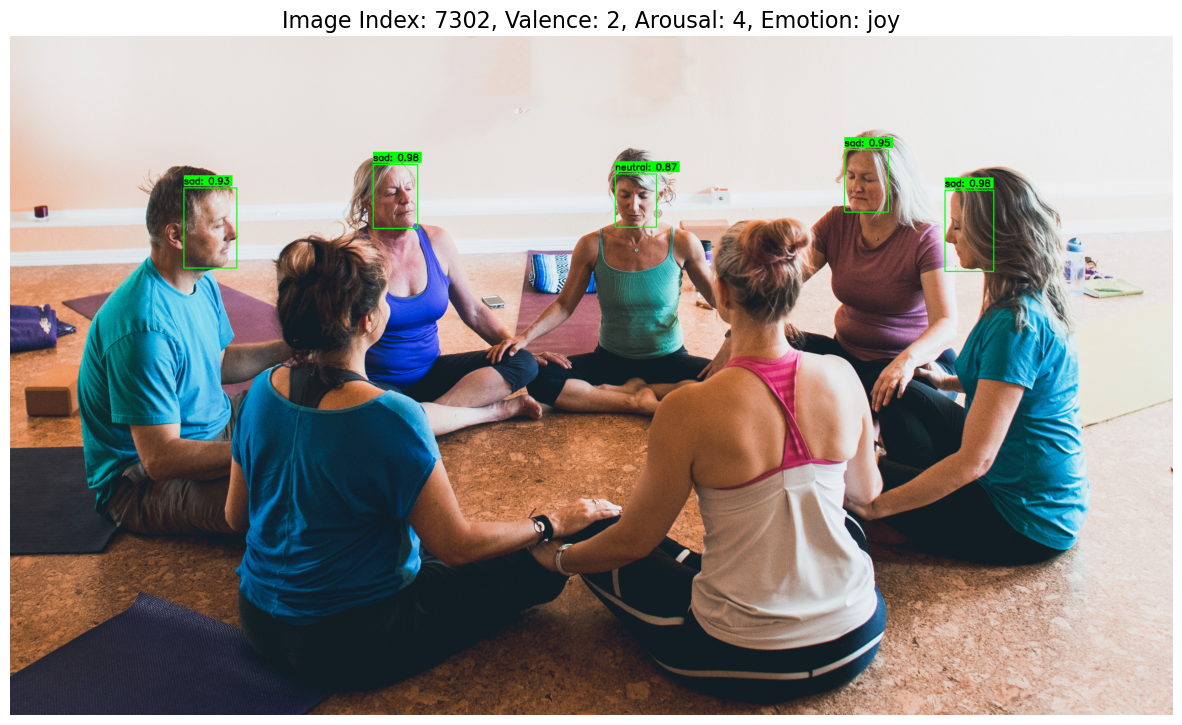

Base model (365 categories):
  art_school: 0.1921
  sandbox: 0.1552
  classroom: 0.1233


Testing: test_va
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,4.13,2.62): 0.1763
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,3.85,2.73): 0.1425
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,3.79,2.52): 0.1132
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,4.32,2.56): 0.0513
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,3.83,2.95): 0.0457
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,4.73,3.23): 0.0421
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,4.21,3.33): 0.0261
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,3.16,3.09): 0.0254
  test_va(tensor(face_predictions(7302)),tensor(scene_predictions(7302)),0.9,1.5,3.91,2.74): 

In [40]:
test_idx = random.choice(test_indices)
show_pretrained_model_predictions_on_sample(test_idx)

# debug_query(model,
#             "test_face_val_bin",
#             Term("tensor", Term("face_features_test", Constant(test_idx))),
#             Var("VBin"))

# debug_query(model,
#             "test_face_aro_bin",
#             Term("tensor", Term("face_features_test", Constant(test_idx))),
#             Var("ABin"))

# debug_query(model,
#             "test_scene_val_bin",
#             Term("tensor", Term("scene_features_test", Constant(test_idx))),
#             Var("VBin"))

# debug_query(model,
#             "test_scene_aro_bin",
#             Term("tensor", Term("scene_features_test", Constant(test_idx))),
#             Var("ABin"))

# debug_query(model,
#             "test_combine_val_bin",
#             Term("tensor", Term("face_features_test", Constant(test_idx))),
#             Term("tensor", Term("scene_features_test", Constant(test_idx))),
#             Var("CV"))

debug_query(model,
            "test_va",
            Term("tensor", Term("face_predictions", Constant(test_idx))),
            Term("tensor", Term("scene_predictions", Constant(test_idx))),
            Var("FV"),
            Var("FA"),
            Var("SV"),
            Var("SA"))

debug_query(model,
            "test_combo",
            Term("tensor", Term("face_predictions", Constant(test_idx))),
            Term("tensor", Term("scene_predictions", Constant(test_idx))),
            Var("CA"),
            Var("CV"))

debug_query(model,
            "final_emotion",
            Term("tensor", Term("face_predictions", Constant(test_idx))),
            Term("tensor", Term("scene_predictions", Constant(test_idx))),
            Var("Emotion"))

print("Debugging queries done.")

In [41]:
train_obj = train_model(
    model,
    train_loader,
    5,
    batch_size=batch_size,
    log_iter=log_iter,
    test_iter = 20 * log_iter,
    test=lambda x :[
        ("test_accuracy", evaluate_dpl_with_metrics(model, test_dataset)['accuracy'])
    ],
    initial_test = False
)

Training  for 5 epoch(s)
Epoch 1
Iteration:  2 	s:15.6673 	Average Loss:  1.2206606520339847
0.786962936631804	0.21303706336819592	0.25849629450263606	0.7415037054973638	0.25389940524189863	0.7461005947581014	0.5642774402467451	0.43572255975325497
Iteration:  4 	s:29.8769 	Average Loss:  2.847869024728425
0.7088589070165432	0.2911410929834568	0.3216337300360652	0.6783662699639348	0.27535028317903043	0.7246497168209696	0.5634056878915416	0.4365943121084585
Iteration:  6 	s:23.5927 	Average Loss:  2.8826412233756855
0.6562238418555755	0.34377615814442447	0.3609295959543864	0.6390704040456137	0.29370041025593985	0.7062995897440602	0.5587357229573764	0.4412642770426238
Iteration:  8 	s:22.5828 	Average Loss:  2.3783355114865117
0.6180414040978279	0.38195859590217207	0.40144956238731294	0.598550437612687	0.3075951530985592	0.6924048469014407	0.5554582429725261	0.4445417570274739
Iteration:  10 	s:31.7422 	Average Loss:  2.244612152397167
0.5840872399770605	0.4159127600229395	0.4264077229435

Accuracy:  0.316

Overall Metrics:
Accuracy: 0.3160

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1872       0.3608       0.2465       97        
anticipation    0.2917       0.1284       0.1783       218       
disgust         0.0000       0.0000       0.0000       44        
fear            0.0000       0.0000       0.0000       86        
joy             0.5870       0.6300       0.6078       273       
sadness         0.1994       0.5841       0.2973       113       
surprise        0.0000       0.0000       0.0000       24        
trust           0.1630       0.1034       0.1266       145       
----------------------------------------------------------------------
Macro Avg       0.1785       0.2259       0.1821       1000      
Weighted Avg    0.2882       0.3160       0.2807       1000      
Test:  [('test_accuracy', 0.316)]
Iteration:  42 	s:1701.089

Accuracy:  0.315

Overall Metrics:
Accuracy: 0.3150

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1813       0.3196       0.2313       97        
anticipation    0.2955       0.1193       0.1699       218       
disgust         0.3333       0.0227       0.0426       44        
fear            0.0000       0.0000       0.0000       86        
joy             0.5762       0.6374       0.6052       273       
sadness         0.2035       0.6106       0.3053       113       
surprise        0.0000       0.0000       0.0000       24        
trust           0.1489       0.0966       0.1172       145       
----------------------------------------------------------------------
Macro Avg       0.2173       0.2258       0.1839       1000      
Weighted Avg    0.2985       0.3150       0.2781       1000      
Test:  [('test_accuracy', 0.315)]
Iteration:  82 	s:1676.061

Accuracy:  0.311

Overall Metrics:
Accuracy: 0.3110

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1902       0.3196       0.2385       97        
anticipation    0.2838       0.0963       0.1438       218       
disgust         0.0000       0.0000       0.0000       44        
fear            0.0000       0.0000       0.0000       86        
joy             0.5597       0.6520       0.6024       273       
sadness         0.2085       0.6106       0.3108       113       
surprise        0.0000       0.0000       0.0000       24        
trust           0.1429       0.0828       0.1048       145       
----------------------------------------------------------------------
Macro Avg       0.1731       0.2202       0.1750       1000      
Weighted Avg    0.2774       0.3110       0.2693       1000      
Test:  [('test_accuracy', 0.311)]
Iteration:  122 	s:1994.66

Accuracy:  0.3

Overall Metrics:
Accuracy: 0.3000

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1842       0.2887       0.2249       97        
anticipation    0.2979       0.0642       0.1057       218       
disgust         0.0909       0.0455       0.0606       44        
fear            0.0000       0.0000       0.0000       86        
joy             0.5438       0.6593       0.5960       273       
sadness         0.2047       0.6106       0.3067       113       
surprise        0.0000       0.0000       0.0000       24        
trust           0.1061       0.0483       0.0664       145       
----------------------------------------------------------------------
Macro Avg       0.1785       0.2146       0.1700       1000      
Weighted Avg    0.2738       0.3000       0.2545       1000      
Test:  [('test_accuracy', 0.3)]
Iteration:  162 	s:2530.1144 	

Accuracy:  0.3

Overall Metrics:
Accuracy: 0.3000

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1985       0.2784       0.2318       97        
anticipation    0.3214       0.0413       0.0732       218       
disgust         0.1111       0.1136       0.1124       44        
fear            0.2500       0.0116       0.0222       86        
joy             0.5291       0.6667       0.5900       273       
sadness         0.2047       0.6106       0.3067       113       
surprise        0.0303       0.0833       0.0444       24        
trust           0.1250       0.0345       0.0541       145       
----------------------------------------------------------------------
Macro Avg       0.2213       0.2300       0.1793       1000      
Weighted Avg    0.3021       0.3000       0.2499       1000      
Test:  [('test_accuracy', 0.3)]
Iteration:  202 	s:3293.1579 	

Accuracy:  0.295

Overall Metrics:
Accuracy: 0.2950

Per-Class Metrics:
Emotion         Precision    Recall       F1-Score     Support   
----------------------------------------------------------------------
anger           0.1835       0.2062       0.1942       97        
anticipation    0.2600       0.0596       0.0970       218       
disgust         0.1250       0.1591       0.1400       44        
fear            0.0000       0.0000       0.0000       86        
joy             0.5244       0.6703       0.5884       273       
sadness         0.2047       0.6106       0.3067       113       
surprise        0.0357       0.1250       0.0556       24        
trust           0.0000       0.0000       0.0000       145       
----------------------------------------------------------------------
Macro Avg       0.1667       0.2289       0.1727       1000      
Weighted Avg    0.2471       0.2950       0.2428       1000      
Test:  [('test_accuracy', 0.295)]
Iteration:  242 	s:3650.82

KeyboardInterrupt: 